In [ ]:
# Cài đặt các thư viện cần thiết cho huấn luyện
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql import SparkSession
import time 

In [ ]:
# Khởi tạo Spark session
spark = SparkSession.builder.appName("RandomForestKFold").getOrCreate()

# Đọc dữ liệu
df = spark.read.csv("Data/Output.csv/Clear.csv", header=True, inferSchema=True)

# Vector hóa các đặc trưng đầu vào
assembler = VectorAssembler(
    inputCols=["pm25", "pm10", "co", "no2", "so2", "o3", "temperature", "humidity", "rainfall", "wind_speed"],
    outputCol="features"
)
data = assembler.transform(df)

# Gán nhãn số cho nhãn chuỗi "air_quality"
indexer = StringIndexer(inputCol="air_quality", outputCol="label")
indexer_model = indexer.fit(data)
data = indexer_model.transform(data)

# In bảng ánh xạ nhãn
print("Mapping nhãn số sang nhãn chuỗi:")
for i, label in enumerate(indexer_model.labels):
    print(f"Label {i} -> '{label}'")

# Thêm cột ID để chia K-Fold
data_with_id = data.withColumn("id", F.monotonically_increasing_id())

# Chia dữ liệu thành K phần
k = 5
folds = data_with_id.randomSplit([1.0 / k] * k, seed=42)

# Khởi tạo mô hình và các evaluator
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracies, precisions, recalls, f1_scores = [], [], [], []

# Huấn luyện và đánh giá từng fold
for i in range(k):
    print(f"\n=== Fold {i+1}/{k} ===")

    test_data = folds[i]
    train_data = data_with_id.subtract(test_data)

    start_time = time.time()

    model = rf.fit(train_data)
    predictions = model.transform(test_data)

    end_time = time.time()
    elapsed_time = end_time - start_time

    accuracy = accuracy_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    # In kết quả từng fold
    print(f"Accuracy RF    : {accuracy * 100:.5f}")
    print(f"Precision RF   : {precision:.5f}")
    print(f"Recall RF      : {recall:.5f}")
    print(f"F1-Score RF    : {f1_score:.5f}")
    print(f"Time RF        : {elapsed_time:.5f} giây")

# Kết quả trung bình sau tất cả folds
mean_accuracy = sum(accuracies) / k
mean_precision = sum(precisions) / k
mean_recall = sum(recalls) / k
mean_f1_score = sum(f1_scores) / k

print("\n=== Kết quả trung bình trên tất cả folds ===")
print(f"Accuracy trung bình : {mean_accuracy * 100:.5f}")
print(f"Precision trung bình: {mean_precision:.5f}")
print(f"Recall trung bình   : {mean_recall:.5f}")
print(f"F1 Score trung bình : {mean_f1_score:.5f}")

# Lưu mô hình 
model.save("./random_forest_model")


Mapping nhãn số sang nhãn chuỗi:
Label 0 -> 'Kém'
Label 1 -> 'Rất Kém'
Label 2 -> 'Trung bình'
Label 3 -> 'Tốt'

=== Fold 1/5 ===
Accuracy RF    : 94.04925
Precision RF   : 0.96169
Recall RF      : 0.93789
F1-Score RF    : 0.94134
Time RF        : 5.09797 giây

=== Fold 2/5 ===
Accuracy RF    : 93.22121
Precision RF   : 0.99946
Recall RF      : 0.89013
F1-Score RF    : 0.93337
Time RF        : 4.67258 giây

=== Fold 3/5 ===
Accuracy RF    : 94.27455
Precision RF   : 0.96866
Recall RF      : 0.93738
F1-Score RF    : 0.94387
Time RF        : 4.47473 giây

=== Fold 4/5 ===
Accuracy RF    : 93.53553
Precision RF   : 0.93531
Recall RF      : 0.95033
F1-Score RF    : 0.93675
Time RF        : 4.31557 giây

=== Fold 5/5 ===
Accuracy RF    : 94.07305
Precision RF   : 0.95994
Recall RF      : 0.94179
F1-Score RF    : 0.94161
Time RF        : 5.07548 giây

=== Kết quả trung bình trên tất cả folds ===
Accuracy trung bình : 93.83072
Precision trung bình: 0.96501
Recall trung bình   : 0.93150
F1 Sco

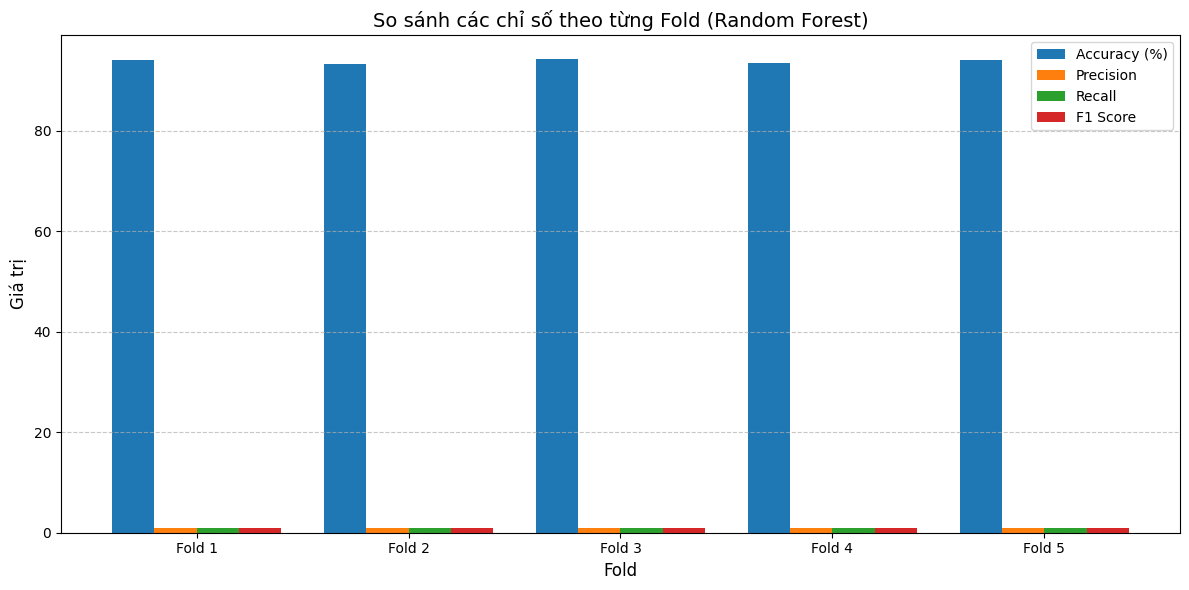

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Danh sách số fold
folds = list(range(1, k + 1))

# Chuyển đổi Accuracy về phần trăm cho dễ nhìn
accuracies_pct = [x * 100 for x in accuracies]

# Tạo dữ liệu dạng numpy array
metrics = {
    'Accuracy (%)': accuracies_pct,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
}

# Số lượng chỉ số cần vẽ
num_metrics = len(metrics)
bar_width = 0.2
x = np.arange(len(folds))  

plt.figure(figsize=(12, 6))

# Vẽ từng chỉ số
for i, (metric_name, values) in enumerate(metrics.items()):
    plt.bar(x + i * bar_width, values, width=bar_width, label=metric_name)

plt.xlabel('Fold', fontsize=12)
plt.ylabel('Giá trị', fontsize=12)
plt.title('So sánh các chỉ số theo từng Fold (Random Forest)', fontsize=14)
plt.xticks(x + bar_width * (num_metrics - 1) / 2, [f'Fold {i}' for i in folds])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("rf_fold_comparison.png")
plt.show()
